## **Ratio Metrics Analysis**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import norm, ttest_ind
from datetime import datetime
import os

### Different Approaches

Мы поговорим о различных способах построения метрик, сравним их плюсы и минусы, 
обсудим возможность применения тех или иных статистических критериев.

В фокусе нашего внимания будут:
- Пользовательские метрики
- Ratio-метрики
- Линеаризация для ratio-метрик
- Применение бутстрепа и дельта-метода для указанных случаев

#### User Sessions Data Generation

Будем генерировать пользователей со случайным количеством сессий от 3 до 9. 
У каждого пользователя будет своя средняя длина сессии, 
множество сессий пользователя будет генерироваться просто добавлением шума к средней длине сессии пользователя.


In [22]:
def get_session_duration(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: List[np.array], список массивов,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    def _user_sessions(mean):
        size = np.random.randint(3,10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    return [_user_sessions(mean) for mean in mean_durations]


Функция генерации сессий возвращает список со списками,
где каждый внутренний список - это список длительности сессий:

In [23]:
get_session_duration(5, effect=0, seed=None)

[array([ 78.,  75.,  81., 121.,  64.,  80.,  79.]),
 array([121., 124., 116., 115., 125., 110., 116., 114., 142.]),
 array([ 97.,  95.,  89., 102.,  97.,  92.,  88.,  88., 121.]),
 array([ 91.,  99., 106., 112.,  97.]),
 array([107., 100., 105.])]

#### Functions for P-value Distribution 

Корректно работающий тест дает равномерное распределение p-value для A/A-теста. 
Действительно, p-value показывает вероятность получить такое-же или большее значение статистики 
при справедливости нулевой гипотезы. Из этого автоматически следует выше написанное утверждение.

С помощью библиотеки [Seaborn](https://seaborn.pydata.org/index.html) 
мы построим визуальное отображение для эмпирических функций распределения p-value. Для этого нам понадобятся:

- [seaborn.histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html):
    ```
    seaborn.histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, 
        discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, 
        shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, 
        cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    ```
- [seaborn.ecdfplot](https://seaborn.pydata.org/generated/seaborn.ecdfplot.html):
    ```
    seaborn.ecdfplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='proportion', complementary=False, 
        palette=None, hue_order=None, hue_norm=None, log_scale=None, legend=True, ax=None, **kwargs)
    ```


In [24]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

Проверим наши рассуждения на примере нормального распределения:

  0%|          | 0/5000 [00:00<?, ?it/s]

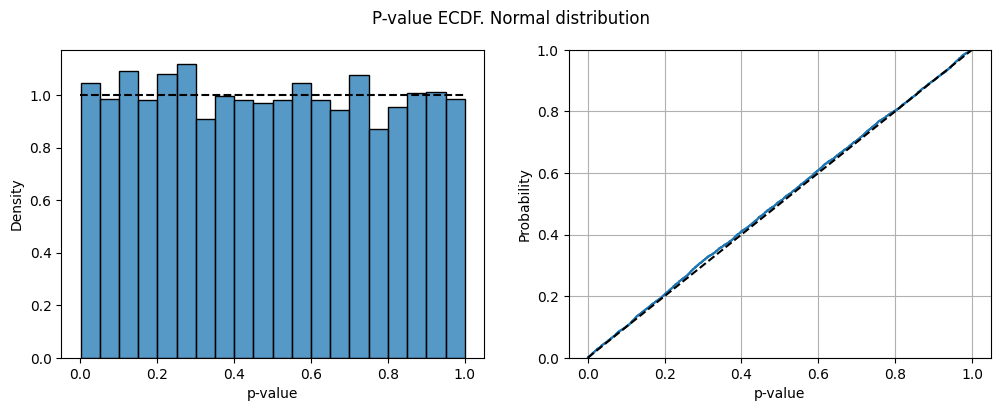

In [25]:
def get_pvalue_samples(a_sample_generator, b_sample_generator, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        _, p = stats.ttest_ind(a_sample_generator(), b_sample_generator())
        pvalues.append(p)
    return pvalues

pvalues = get_pvalue_samples(
    a_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    b_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    size=5000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

Ожидания выполнены - видим распределение близкое к равномерному.

### "Naive" Approach and Dependent Data Problem

Посмотрим, что произойдет с тестом при наивном применении,
т.е. когда мы **в качестве случайных величин возьмем длины сессий пользователей в экспериментальной и контрольной группах**
(не задумываясь о том, к какому пользователю относится конкретная сессия):

  0%|          | 0/1000 [00:00<?, ?it/s]

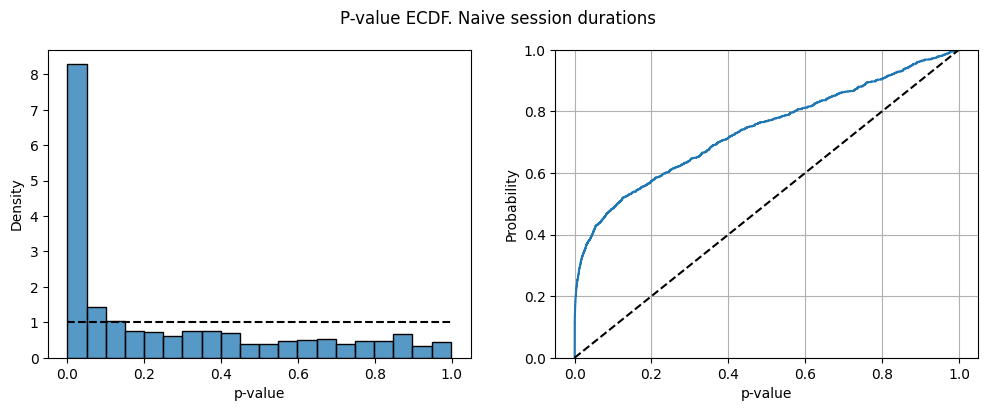

In [26]:
def check_ttest_naive(a, b):
    """Проверка гипотезы с помощью наивного среднего по длинам сессий.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_naive = np.concatenate(a)
    b_naive = np.concatenate(b)
    _, pvalue = stats.ttest_ind(a_naive, b_naive)
    delta = b_naive.mean() - a_naive.mean()
    return pvalue, delta

def naive_session_durations(size=100, effect=0):
    def _durations():
        durations = get_session_duration(size=size, effect=effect)
        return np.concatenate(durations)
    return _durations

pvalues = get_pvalue_samples(
    a_sample_generator=naive_session_durations(size=100, effect=0),
    b_sample_generator=naive_session_durations(size=100, effect=0),
    size=1000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Naive session durations')

Мы видим, что полученное распределение сильно неравномерное, **это говорит о неверно сконструированном тесте**. 

P-value < 0.05 примерно в 40% случаев, то есть в 40% случаев мы отклонили нулевую гипотезу, когда она была верна.

Всё это связано с тем, что **длины сессий не будут независимыми** - для каждого пользователя 
вообще говоря будет свое распределение. И неравенство в выборе приводит к таким плачевным результатам.


### Mean of Means

Не всегда, но очень часто, **мы можем предполагать независимость действий отдельных пользователей**,
поэтому **и статистики для пользователей должны быть независимыми**.

Попробуем посчитать для каждого пользователя среднюю сессию, тем самым получив для каждого пользователя
одно значение, а затем проведем A/A-тесты (т.е. будем с помощью t-test сравнивать средние средних сессий)
и посмотрим на распределени p-value и направленность метрики:


  0%|          | 0/1000 [00:00<?, ?it/s]

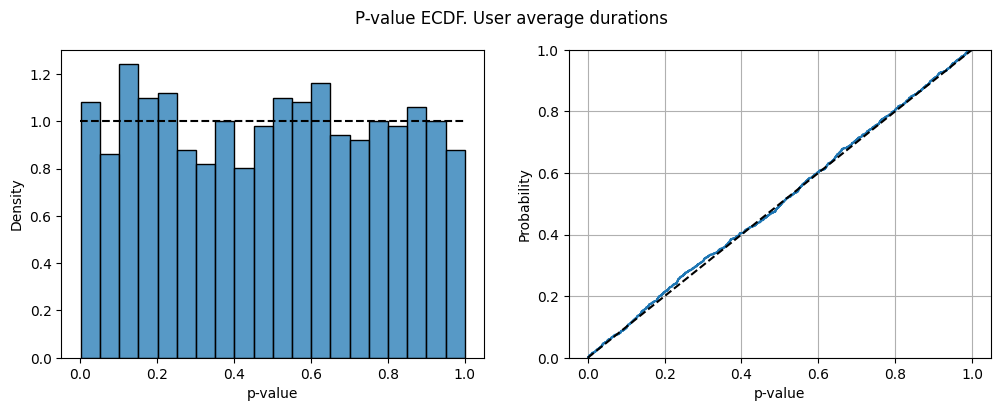

In [27]:
def check_ttest_avg(a, b):
    """Проверка гипотезы с помощью среднего по пользователям.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_avg = [t.mean() for t in a]
    b_avg = [t.mean() for t in b]
    _, pvalue = stats.ttest_ind(a_avg, b_avg)
    delta = np.mean(b_avg) - np.mean(a_avg)
    return pvalue, delta

def user_average_durations(size=100, effect=0):
    def _durations():
        durations = get_session_duration(size=size, effect=effect)
        return [t.mean() for t in durations]
    return _durations

pvalues = get_pvalue_samples(
    a_sample_generator=user_average_durations(size=100, effect=0),
    b_sample_generator=user_average_durations(size=100, effect=0),
    size=1000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. User average durations')

P-value распределено равномерно. Сравним направленность метрик (**среднее средних сессий** и **средняя сессия,
посчитанная "наивным" способом**):

  0%|          | 0/1000 [00:00<?, ?it/s]

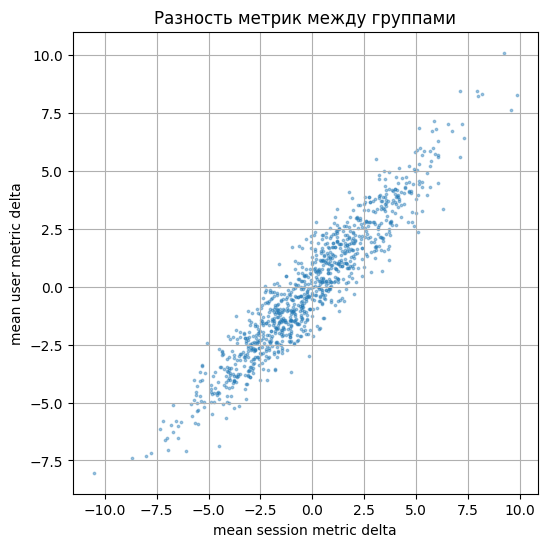

In [28]:
list_session_mean = []
list_user_avg_mean = []

def get_naive_mean_delta(a, b):
    return np.concatenate(b).mean() - np.concatenate(a).mean()

def get_user_avg_mean_delta(a, b):
    return np.mean([t.mean() for t in b]) - np.mean([t.mean() for t in a])

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    list_session_mean.append(get_naive_mean_delta(a, b))
    list_user_avg_mean.append(get_user_avg_mean_delta(a, b))

plt.figure(figsize=(6,6))
plt.scatter(list_session_mean, list_user_avg_mean, s=3, alpha=0.4)
plt.ylabel('mean user metric delta')
plt.xlabel('mean session metric delta')
plt.title('Разность метрик между группами')
plt.grid()
plt.show()

Видно, что есть точки в **верхнем левом и в правом нижнем квадранте**, 
для данных соответствующих этим точкам **направленность метрики не сохраняется**.

Другими словами, мы имеем дело **с двумя разными метриками**.


### Bootstrap

Будем сэплировать **пользователей из групп** и считать разность ratio метрики.
Другими словами, посчитаем точечную оценку (средняя сессия по группе B - средняя сессия по группе A),
затем с помощью бутстрепа будем делать подвыборки из данных пользователей групп A и B,
считать разность 

In [30]:
def check_bootstrap(a, b, n=1000):
    """Проверка гипотезы с помощью бутстрепа по пользователям.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    n: int, кол-во итераций бутстрепа
    
    return: pvalue и точечную оценку.
    """
    len_a = len(a)
    len_b = len(b)
    # предобработаем данные
    # посчитаем заранее сумму длин сессий и их кол-во для каждого пользователя
    a_sum_count = np.zeros((len_a, 2))
    a_sum_count[:, 0] = np.array([np.sum(row) for row in a]) # суммы длин сессий для каждого юзера A
    a_sum_count[:, 1] = np.array([len(row) for row in a]) # количество сессий для каждого юзера A
    b_sum_count = np.zeros((len_b, 2))
    b_sum_count[:, 0] = np.array([np.sum(row) for row in b]) # суммы длин сессий для каждого юзера B
    b_sum_count[:, 1] = np.array([len(row) for row in b]) # количество сессий для каждого юзера B
    
    list_diff = []
    for _ in range(n): # семплируем пользователей
        a_bootstrap_index = np.random.choice(np.arange(len_a), len_a)
        b_bootstrap_index = np.random.choice(np.arange(len_b), len_b)
        a_bootstrap = a_sum_count[a_bootstrap_index]
        b_bootstrap = b_sum_count[b_bootstrap_index]
        a_metric = a_bootstrap[:, 0].sum() / a_bootstrap[:, 1].sum()
        b_metric = b_bootstrap[:, 0].sum() / b_bootstrap[:, 1].sum()
        list_diff.append(b_metric - a_metric)
        
    delta = (
        b_sum_count[:, 0].sum() / b_sum_count[:, 1].sum()
        - a_sum_count[:, 0].sum() / a_sum_count[:, 1].sum()
    ) # точечная оценка разности средней сессии между A и B
    std = np.std(list_diff) # считаем std, чтобы посчитать p-value вместо ДИ
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(delta / std)))
    return pvalue, delta

Проверим наличие у этого способа недостатков прошлых методов: неравномерность pvalue на A/A-тесте и направленность.

In [31]:
# cell time = 1m16s

list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    pvalue, delta = check_bootstrap(a, b)
    list_real_delta.append(get_naive_mean_delta(a, b))
    list_delta.append(delta)
    list_pvalue.append(pvalue)

  0%|          | 0/1000 [00:00<?, ?it/s]

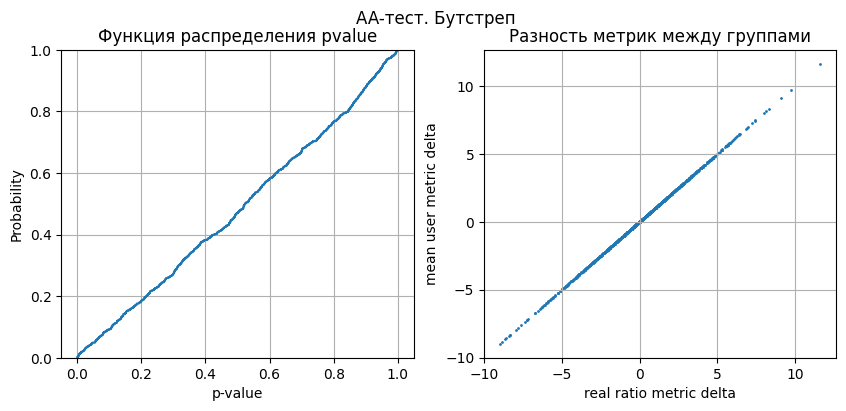

In [32]:
def plot_two_graphs(list_pvalue, list_delta, list_real_delta, suptitle=None):
    """Строим распределение pvalue и граффик направленности.
  
    list_pvalue: pvalue метода
    list_delta: разность метрик между группами метода
    list_delta: разность изначальной ratio метрики между группами
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,4])

    if suptitle:
        plt.suptitle(suptitle)
    sns.ecdfplot(list_pvalue, ax=ax1)
    ax1.set_ylabel('Probability')
    ax1.set_xlabel('p-value')
    ax1.set_title('Функция распределения pvalue')
    ax1.grid()

    ax2.scatter(list_real_delta, list_delta, s=1)
    ax2.set_ylabel('mean user metric delta')
    ax2.set_xlabel('real ratio metric delta')
    ax2.set_title('Разность метрик между группами')
    ax2.grid()

    plt.show()

plot_two_graphs(list_pvalue, list_delta, list_real_delta, suptitle='AA-тест. Бутстреп')

P-value распределено равномерно, направленность сохраняется.

Отметим, что **время вычислений заметно увеличилась**.

**Проверим, может ли такой метод отловить эффект**

Увеличим длину сессий в группе **b**:

  0%|          | 0/100 [00:00<?, ?it/s]

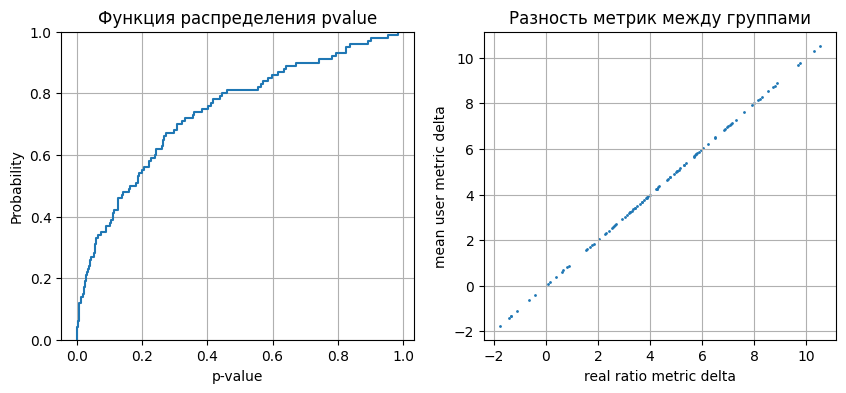

In [33]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(100)):
    a = get_session_duration(100)
    b = get_session_duration(100, effect=0.05)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_bootstrap(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

plot_two_graphs(list_pvalue, list_delta, list_real_delta)

Видно, что распределение p-value сместилось ближе к нулю, то есть нулевая гипотеза стала чаще отвергаться,
т.е. метод рабочий.

### Delta Method

Реализуем дельта-метод, т.е. рассчитаем по формуле дисперсию метрики отношения, которая нас интересует:

In [34]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта метод.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    dict_stats = {'a': {'data': a}, 'b': {'data': b}}
    for key, dict_ in dict_stats.items():
        data = dict_['data']
        dict_['x'] = np.array([np.sum(row) for row in data])
        dict_['y'] = np.array([len(row) for row in data])
        dict_['metric'] = np.sum(dict_['x']) / np.sum(dict_['y'])
        dict_['len'] = len(data)
        dict_['mean_x'] = np.mean(dict_['x'])
        dict_['mean_y'] = np.mean(dict_['y'])
        dict_['std_x'] = np.std(dict_['x'])
        dict_['std_y'] = np.std(dict_['y'])
        dict_['cov_xy'] = np.cov(dict_['x'], dict_['y'])[0, 1]
        dict_['var_metric'] = (
            (dict_['std_x'] ** 2) / (dict_['mean_y'] ** 2)
            + (dict_['mean_x'] ** 2) / (dict_['mean_y'] ** 4) * (dict_['std_y'] ** 2)
            - 2 * dict_['mean_x'] / (dict_['mean_y'] ** 3) * dict_['cov_xy']
        ) / dict_['len']
    var = dict_stats['b']['var_metric'] + dict_stats['a']['var_metric']
    delta = dict_stats['b']['metric'] - dict_stats['a']['metric']
    statistic = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(statistic))) * 2
    return pvalue, delta

Проведём проверки аналогичные бутстрепу

  0%|          | 0/1000 [00:00<?, ?it/s]

Эффекта нет


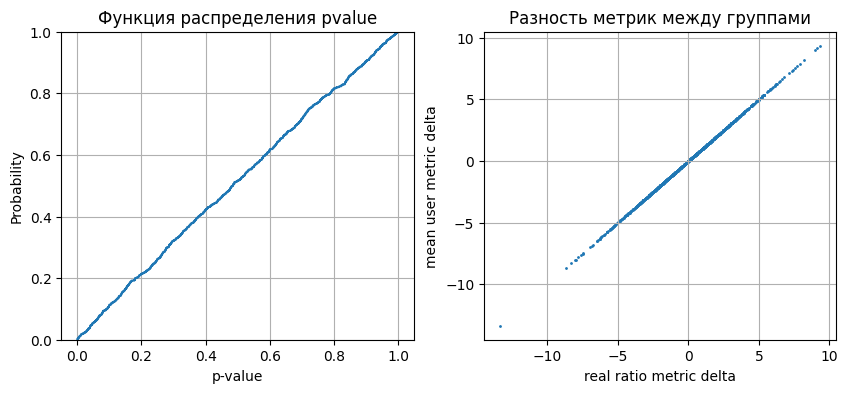

In [35]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_delta_method(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффекта нет')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)

Теперь добавим эффект и посмотрим, отлавливет ли его дельта-метод:

  0%|          | 0/1000 [00:00<?, ?it/s]

Эффект есть


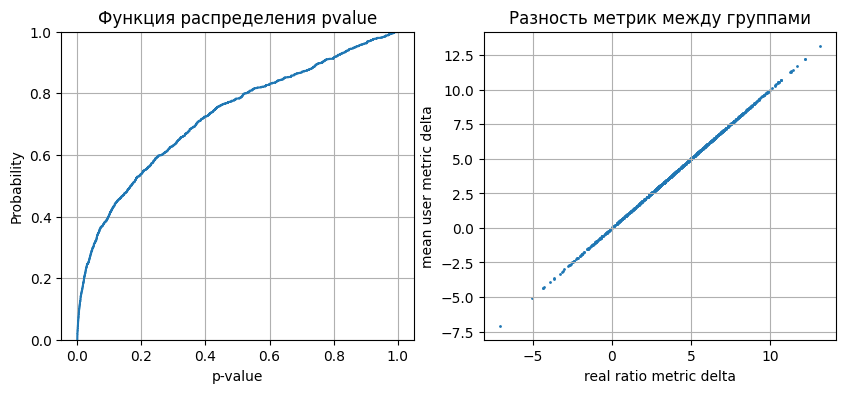

In [36]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100, 0.04)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_delta_method(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффект есть')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)

**Результаты корректные, метод работает**

##  Linearization

Теперь проведем переход от средней сессии (метрики отношения)
к пользовательской линеаризованной метрике:

In [37]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

  0%|          | 0/1000 [00:00<?, ?it/s]

Эффекта нет


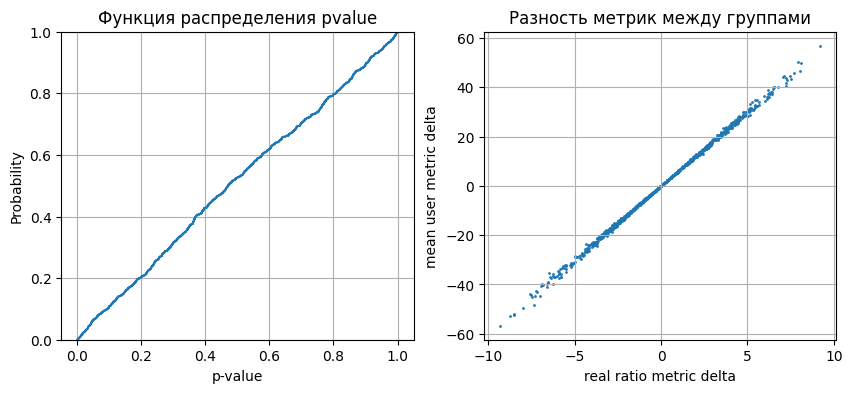

In [38]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_linearization(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффекта нет')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)

  0%|          | 0/1000 [00:00<?, ?it/s]

Эффект есть


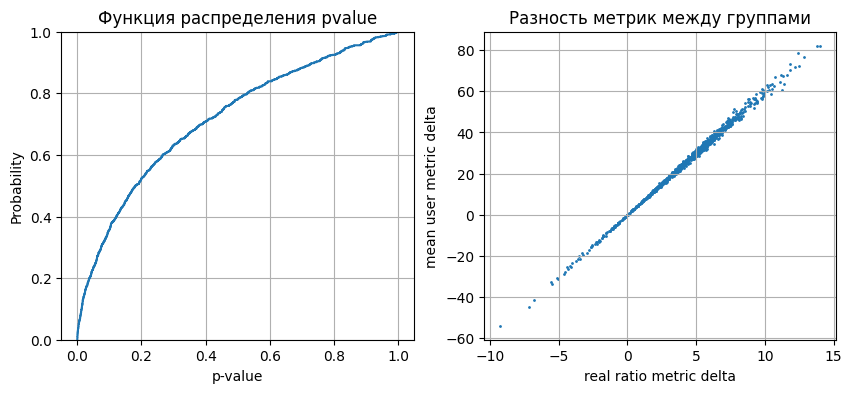

In [39]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100, 0.04)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_linearization(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффект есть')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)

Получаем ожидаемые **корректные результаты**, при этом теперь мы имеем дело с 
пользовательской метрикой, а значит - можем применять методы снижения дисперсии.

### All Approaches Together

Посмотрим на методы вместе - будем генерировать данные и считать значения приращения метрик и pvalue всеми способами, 
и отобразим полученные результаты на графиках.

In [40]:
dict_check = {
    'bootstrap': check_bootstrap,
    'naive': check_ttest_naive,
    'avg': check_ttest_avg,
    'delta': check_delta_method,
    'linearization': check_linearization
}

res_dict = {key: {'pvalue': [], 'delta': []} for key in dict_check}
for _ in tqdm(range(200)):
    a = get_session_duration(100)
    b = get_session_duration(100, effect=np.random.choice([0, -0.05, 0.05]))
    for method_name, method_func in dict_check.items():
        pvalue, delta = method_func(a, b)
        res_dict[method_name]['pvalue'].append(pvalue)
        res_dict[method_name]['delta'].append(delta)

  0%|          | 0/200 [00:00<?, ?it/s]

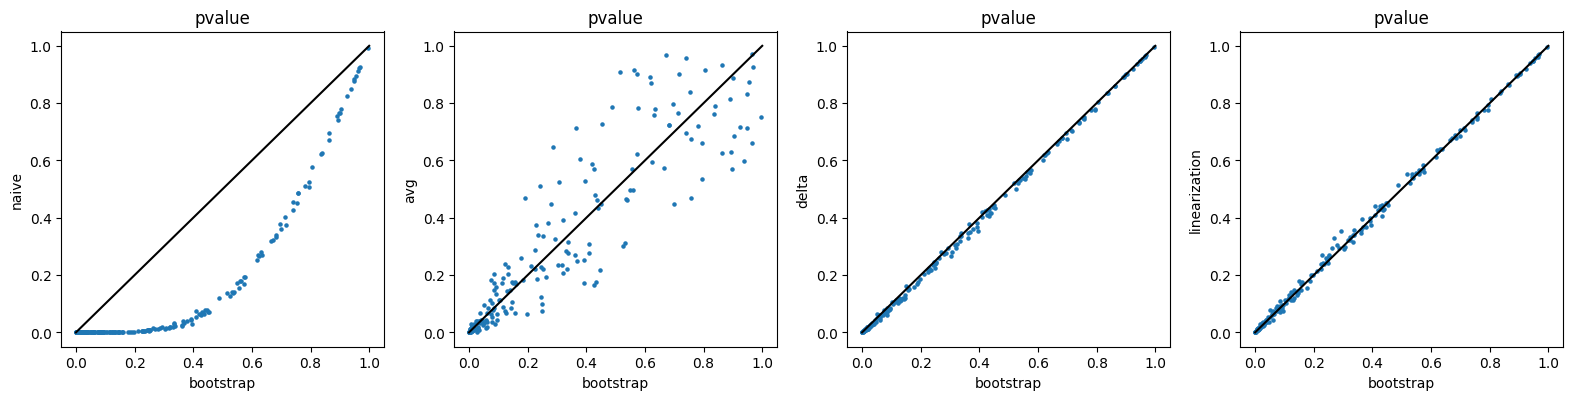

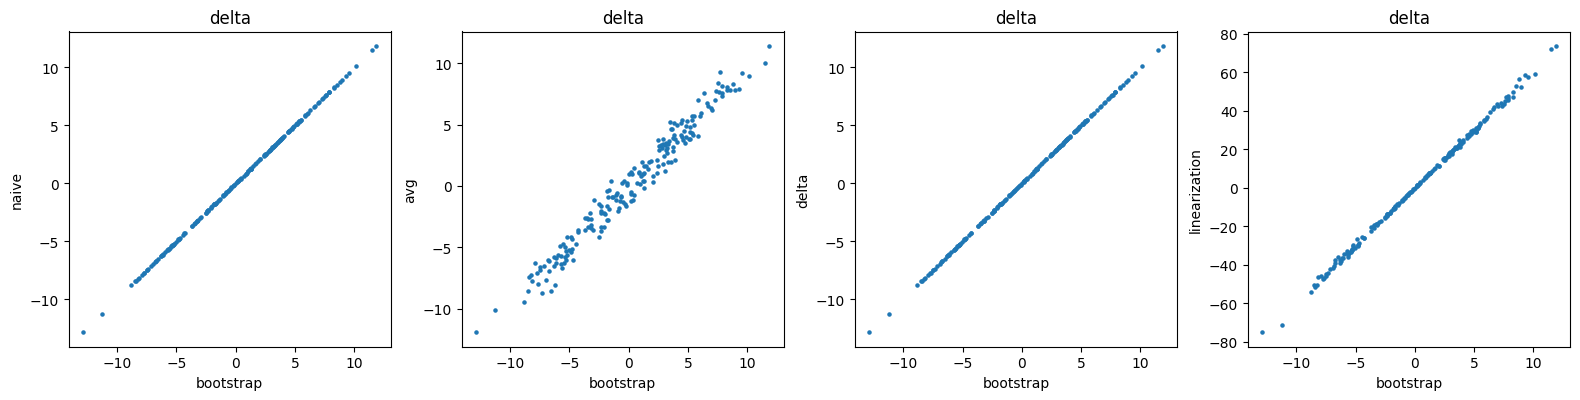

In [41]:
pvalues_bootstrap = res_dict['bootstrap']['pvalue']
deltas_bootstrap = res_dict['bootstrap']['delta']

for data_type in ['pvalue', 'delta']:
    fig, axes = plt.subplots(1, len(res_dict) - 1, figsize=[16, 4])
    fig.tight_layout(pad=2)
    plot_id = 0
    for key in res_dict:
        if key == 'bootstrap':
            continue
        axes[plot_id].scatter(res_dict['bootstrap'][data_type], res_dict[key][data_type], s=5)
        if data_type == 'pvalue':
            axes[plot_id].plot([0, 1], [0, 1], 'k')
        axes[plot_id].set_ylabel(key)
        axes[plot_id].set_xlabel('bootstrap')
        axes[plot_id].set_title(data_type)
        plot_id += 1
    plt.show()

В верхнем ряду графики для pvalue, в нижнем для разности метрик.

По оси абсцисс везде бутстреп, по оси ординат остальные методы.

- Видно, что первые два метода отличаются от остальных и дают некорректные pvalue.
- Результаты бустрепа, дельта метода и метода линеаризации очень похожи.
- Бутстреп плох сложностью вычислений, которые занимают много времени.

Преимущество линеаризации над дельта-методом в наличии пользовательской метрики, 
поэтому давайте придумаем пример, где это может дать преимущество.

### Delta Method vs. Linearization

Нам понадобятся **данные о пользовательских сессиях до пилота**. 
Пусть там будет случайно кол-во сессий от 3 до 9, но то же среднее значение продолжительности сессии.


In [42]:
def get_session_duration_with_prepilot(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: (List[np.array], List[np.array]), пара списков с массивами до пилота и во время пилота,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    if seed:
        np.random.seed(seed)
    mean_durations = np.random.normal(100, 20, size)
    count_sessions = np.random.randint(3, 10, size)
    count_sessions_before = np.random.randint(3, 10, size)
    data = []
    data_before = []
    zip_data = zip(mean_durations, count_sessions, count_sessions_before)
    for mean_duration, count_session, count_session_before in zip_data:
        data.append((np.random.normal(0, 10, count_session) + mean_duration * (1 + effect)).round())
        data_before.append((np.random.normal(0, 10, count_session_before) + mean_duration).round())
    return data_before, data

In [43]:
get_session_duration_with_prepilot(3, 0.1)

([array([ 98., 111., 120.,  96., 124.]),
  array([100., 112., 101.,  92.,  90.,  87.,  90., 110.]),
  array([59., 58., 60., 73., 58., 55., 80.])],
 [array([109., 126., 107., 131., 119., 123., 115., 102., 127.]),
  array([106., 112., 106., 110.]),
  array([66., 63., 71., 69., 68., 52.])])

Сгенерируем данные для пилотной и контрольной групп:

In [45]:
size = 10000

np.random.seed(23)

data_pilot_before, data_pilot = get_session_duration_with_prepilot(size, 0.01)
data_control_before, data_control = get_session_duration_with_prepilot(size)

Посчитаем pvalue с помощью дельта метода и метода линеаризации:

In [46]:
pvalue, delta = check_delta_method(data_control, data_pilot)
print(f'pvalue delta method {pvalue:0.4f}')

pvalue, delta = check_linearization(data_control, data_pilot)
print(f'pvalue linearization {pvalue:0.4f}')

pvalue delta method 0.3581
pvalue linearization 0.3605


Оба метода не отвергли нулевую гипотезу на уровне значимости 0.05.

Для линеаризации мы имеем пользовательскую метрику. 
**Можем применить способ понижения дисперсии CUPED**

In [47]:
# создадим датафреймы для пилотной и контрольной группы с метриками
df_pilot = pd.DataFrame({
    'x': [np.sum(x) for x in data_pilot],
    'y': [len(x) for x in data_pilot],
    'x_before': [np.sum(x) for x in data_pilot_before],
    'y_before': [len(x) for x in data_pilot_before],
})
df_control = pd.DataFrame({
    'x': [np.sum(x) for x in data_control],
    'y': [len(x) for x in data_control],
    'x_before': [np.sum(x) for x in data_control_before],
    'y_before': [len(x) for x in data_control_before],
})

# коэффициент для функции линеаризации
coef_lin = df_control['x'].sum() / df_control['y'].sum()
print(f'coef_lin = {coef_lin:0.2f}')

# добавим значения линеаризованных метрик пользователей
for df_ in [df_pilot, df_control]:
    df_['metric_lin'] = df_['x'] - coef_lin * df_['y']
    df_['metric_lin_before'] = df_['x_before'] - coef_lin * df_['y_before']

coef_lin = 100.12


Посмотрим как выглядит полученный датафрейм

In [48]:
df_pilot.head(3)

,x,y,x_before,y_before,metric_lin,metric_lin_before
0,899.0,8,480.0,4,98.031745,79.515872
1,940.0,9,288.0,3,38.910713,-12.363096
2,798.0,9,420.0,5,-103.089287,-80.605159


In [49]:
stats.ttest_ind(df_pilot['metric_lin'], df_control['metric_lin'])

TtestResult(statistic=0.9144757175706572, pvalue=0.3604779571546779, df=19998.0)

**P-value совпадает с полученным ранее**

#### CUPED

Применим CUPED для линеаризованной метрики

In [50]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    """Вычисляем Theta.
    
    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

theta = calculate_theta(df_control['metric_lin'], df_pilot['metric_lin'], df_control['metric_lin_before'], df_pilot['metric_lin_before'])

for df_ in [df_pilot, df_control]:
    df_['metric_lin_cuped'] = df_['metric_lin'] - theta * df_['metric_lin_before']

Проверим, сохраняется ли направленность точечных оценок:

In [51]:
delta_ratio = (
    df_pilot['x'].sum() / df_pilot['y'].sum()
    - df_control['x'].sum() / df_control['y'].sum()
)
print(f'точеченая оценка изменения изначальной ratio метрики: {delta_ratio:0.2f}')

delta_lin = df_pilot['metric_lin'].mean() - df_control['metric_lin'].mean()
print(f'точеченая оценка изменения для линеаризованной метрики: {delta_lin:0.2f}')

delta_cuped = df_pilot['metric_lin_cuped'].mean() - df_control['metric_lin_cuped'].mean()
print(f'точеченая оценка изменения для линеаризованной и преобразованной c помощью CUPED метрики: {delta_cuped:0.2f}')

точеченая оценка изменения изначальной ratio метрики: 0.28
точеченая оценка изменения для линеаризованной метрики: 1.67
точеченая оценка изменения для линеаризованной и преобразованной c помощью CUPED метрики: 4.30


In [52]:
stats.ttest_ind(df_pilot['metric_lin_cuped'], df_control['metric_lin_cuped'])

TtestResult(statistic=4.72449151512348, pvalue=2.322594728616463e-06, df=19998.0)

Получили p-value < 0.05, то есть **виден значимый эффект на уровне значимости 5%**
(тест отловил маленький эффект за счет применения CUPED и снижения дисперсии)

**Проверка корректности работы Linearization + CUPED:**

In [53]:
pvalues = []
for _ in tqdm(range(4000)):
    size = 100
    data_pilot_before, data_pilot = get_session_duration_with_prepilot(size)
    data_control_before, data_control = get_session_duration_with_prepilot(size)

    # создадим датафреймы для пилотной и контрольной группы с метриками
    df_pilot = pd.DataFrame({
        'x': [np.sum(x) for x in data_pilot],
        'y': [len(x) for x in data_pilot],
        'x_before': [np.sum(x) for x in data_pilot_before],
        'y_before': [len(x) for x in data_pilot_before],
    })
    df_control = pd.DataFrame({
        'x': [np.sum(x) for x in data_control],
        'y': [len(x) for x in data_control],
        'x_before': [np.sum(x) for x in data_control_before],
        'y_before': [len(x) for x in data_control_before],
    })
    # коэффициент для функции линеаризации
    coef_lin = df_control['x'].sum() / df_control['y'].sum()
    # добавим значения линеаризованных метрик пользователей
    for df_ in [df_pilot, df_control]:
        df_['metric_lin'] = df_['x'] - coef_lin * df_['y']
        df_['metric_lin_before'] = df_['x_before'] - coef_lin * df_['y_before']

    theta = calculate_theta(df_control['metric_lin'], df_pilot['metric_lin'], df_control['metric_lin_before'], df_pilot['metric_lin_before'])
    for df_ in [df_pilot, df_control]:
        df_['metric_lin_cuped'] = df_['metric_lin'] - theta * df_['metric_lin_before']

    pvalues.append(
        stats.ttest_ind(df_pilot['metric_lin_cuped'], df_control['metric_lin_cuped'])[1]
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

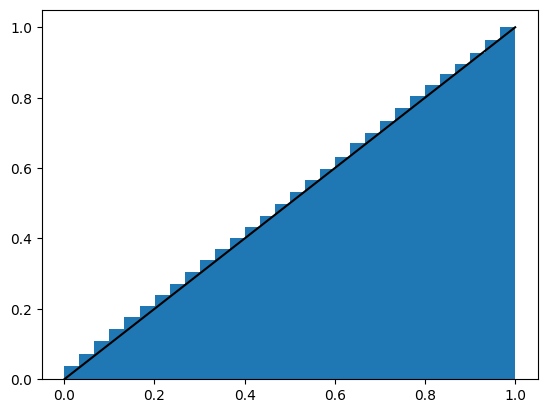

In [54]:
plt.hist(pvalues, bins=30, density=True, cumulative=True)
plt.plot([0,1], [0,1], color='k')

**Тест корректен, p-value распределено равномерно**

### Pizzeria's Data

Предположим, мы хотим спроектировать дизайн эксперимента для целевой метрики средний чек:

In [55]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


sales — таблица с информаций о покупках, одна строка — один заказ. 

1. sale_id — идентификатор покупки;
2. date — дата покупки;
3. count_pizza — количество пицц в заказе;
4. count_drink — количество напитков в заказе;
5. price — стоимость заказа;
6. user_id — идентификатор пользователя.

Предположим, что мы хотим проводить тест в течение 4х недель.

Для этого на историческом промежутке выберем интервал длиной в одну неделю и проведем все расчеты 
для данного промежутка времени. 
Отметим, что сегодня 1 апреля, поэтому мы взяли неделю непосредственно перед запуском эксперимента. 
Данный подход служит неплохой эвристикой.

In [56]:
sales_hist = sales[
    (sales['date'] >= datetime(2022, 3, 1))
    & (sales['date'] < datetime(2022, 3, 29))
]
sales_hist.shape

(101951, 6)

**Вспомним, что покупки одного пользователя зависимы:**

Чтобы проверить корректность дизайна эксперимента, 
мы должны многократно просимулировать этот эксперимент на исторических данных. 
Сначала проверим, контролируется ли вероятность ошибки 1-го рода. 
Для этого объектами в нашей выборке будут **чеки**. 
То есть мы делим всех людей на 2 группы, собираем все чеки назвисимо и проводим t-test.


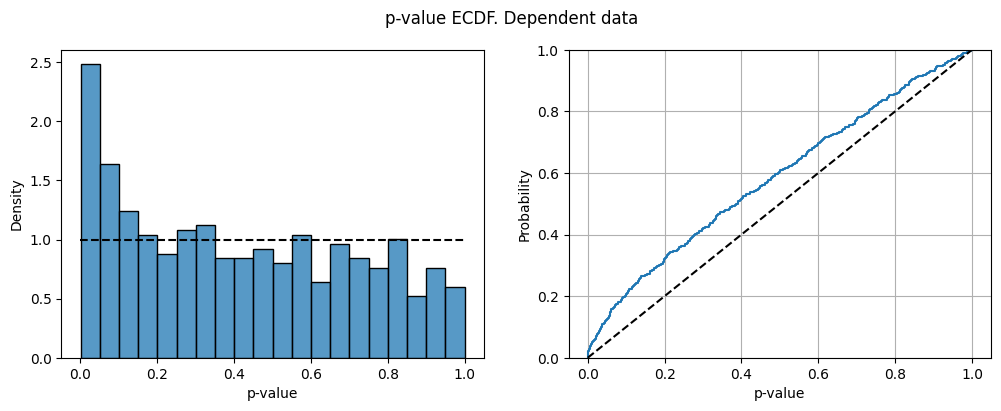

In [57]:
p_values = []
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b = sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

**Теперь каждый раз будем применять линеаризацию:**

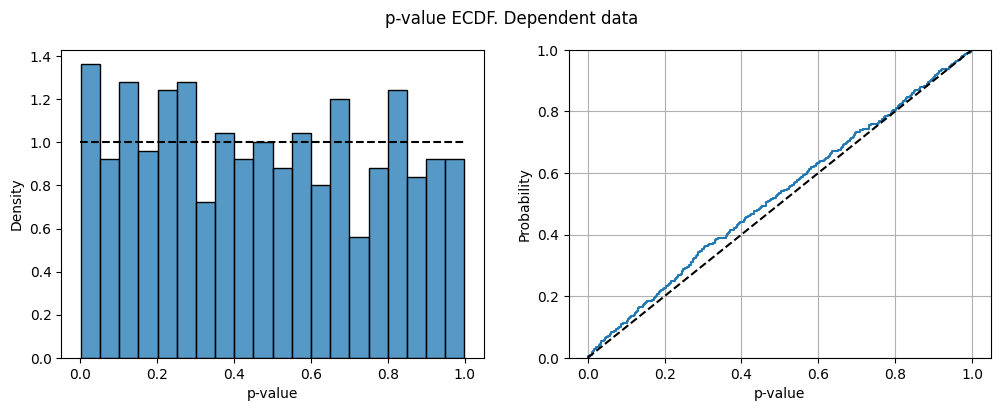

In [58]:
p_values = []
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]

    sales_a = sales_hist[sales_hist['user_id'].isin(group_a)][['user_id', 'price']]
    sales_b = sales_hist[sales_hist['user_id'].isin(group_b)][['user_id', 'price']]

    stat_a = sales_a.groupby('user_id')['price'].agg(['sum', 'count'])
    stat_b = sales_b.groupby('user_id')['price'].agg(['sum', 'count'])

    sum_a, count_a = stat_a.sum()
    sum_b, count_b = stat_b.sum()

    kappa = sum_a / count_a
    linearized_sales_a = stat_a['sum'] - kappa * stat_a['count']
    linearized_sales_b = stat_b['sum'] - kappa * stat_b['count']

    _, p_val = ttest_ind(linearized_sales_a, linearized_sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

### Эксперимент "Refactoring backend"

In [ ]:

# Оценка эксперимента "Refactoring backend" с использованием линеаризации в предположении, что данные пользователей зависимы.
# Данные эксперимента "Refactoring backend": 2022-04-13/2022-04-13T12_df_web_logs.csv и 2022-04-13/experiment_users.csv. 
# Эксперимент проводился с 2022-04-05 по 2022-04-12. 
# Метрика — среднее время обработки запроса.

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from scipy import stats

URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-13/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_web_logs = read_database('2022-04-13T12_df_web_logs.csv')
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])
df_users = read_database('experiment_users.csv')

begin_date = datetime(2022, 4, 5)
end_date = datetime(2022, 4, 12)

In [63]:

df_metrics = (
    df_web_logs
    [(df_web_logs['date'] >= begin_date) & (df_web_logs['date'] < end_date)]
    .groupby('user_id')[['load_time']].agg(list)
    .reset_index()
)
df = pd.merge(df_users, df_metrics, on='user_id', how='left')

def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[List], список множеств длин сессий пользователей контрольной группы
    b: List[List], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

a = df[df['pilot'] == 0]['load_time'].values
b = df[df['pilot'] == 1]['load_time'].values
pvalue = check_linearization(a, b)[0]
print(f'pvalue = {pvalue:0.4f}')


pvalue = 0.0442


### Метод calculate_linearized_metrics класса MetricsService

In [ ]:
# Метод для вычисления метрики отношения.
# Метод calculate_linearized_metrics класса MetricsService.

class MetricsService:

    def calculate_linearized_metrics(
        self, control_metrics, pilot_metrics, control_user_ids=None, pilot_user_ids=None
    ):
        """Считает значения метрики отношения.

        Нужно вычислить параметр kappa (коэффициент в функции линеаризации) по данным из
        control_metrics и использовать его для вычисления линеаризованной метрики.

        :param control_metrics (pd.DataFrame): датафрейм со значениями метрики контрольной группы.
            Значения в столбце 'user_id' не уникальны.
            Измерения для одного user_id считаем зависимыми, а разных user_id - независимыми.
            columns=['user_id', 'metric']
        :param pilot_metrics (pd.DataFrame): датафрейм со значениями метрики экспериментальной группы.
            Значения в столбце 'user_id' не уникальны.
            Измерения для одного user_id считаем зависимыми, а разных user_id - независимыми.
            columns=['user_id', 'metric']
        :param control_user_ids (list): список id пользователей контрольной группы, для которых
            нужно рассчитать метрику. Если None, то использовать пользователей из control_metrics.
            Если для какого-то пользователя нет записей в таблице control_metrics, то его
            линеаризованная метрика равна нулю.
        :param pilot_user_ids (list): список id пользователей экспериментальной группы, для которых
            нужно рассчитать метрику. Если None, то использовать пользователей из pilot_metrics.
            Если для какого-то пользователя нет записей в таблице pilot_metrics, то его
            линеаризованная метрика равна нулю.
        :return lin_control_metrics, lin_pilot_metrics: columns=['user_id', 'metric']
        """
        kappa = control_metrics['metric'].mean()

        dfs = []
        for df, user_ids in [(control_metrics, control_user_ids,), (pilot_metrics, pilot_user_ids,)]:
            df_agg = df.groupby('user_id')[['metric']].agg(['sum', 'count'])
            df_agg.columns = df_agg.columns.get_level_values(1)
            df_agg['metric'] = df_agg['sum'] - kappa * df_agg['count']

            if user_ids:
                df_user = pd.DataFrame({'user_id': user_ids})
            else:
                df_user = pd.DataFrame({'user_id': df_agg.index.values})
            df_res = pd.merge(
                df_user,
                df_agg[['metric']].reset_index(),
                on='user_id',
                how='left'
            ).fillna(0)
            dfs.append(df_res)
        return dfs
    


def _chech_df(df, df_ideal, sort_by, reindex=False, set_dtypes=False, decimal=None):
    assert isinstance(df, pd.DataFrame), 'Функция вернула не pd.DataFrame.'
    assert len(df) == len(df_ideal), 'Неверное количество строк.'
    assert len(df.T) == len(df_ideal.T), 'Неверное количество столбцов.'
    columns = df_ideal.columns
    assert df.columns.isin(columns).sum() == len(df.columns), 'Неверное название столбцов.'
    df = df[columns].sort_values(sort_by)
    df_ideal = df_ideal.sort_values(sort_by)
    if reindex:
        df_ideal.index = range(len(df_ideal))
        df.index = range(len(df))
    if set_dtypes:
        for column, dtype in df_ideal.dtypes.to_dict().items():
            df[column] = df[column].astype(dtype)
    if decimal:
        ideal_values = df_ideal.astype(float).values
        values = df.astype(float).values
        np.testing.assert_almost_equal(ideal_values, values, decimal=decimal)
    else:
        assert df_ideal.equals(df), 'Итоговый датафрейм не совпадает с верным результатом.'


if __name__ == '__main__':
    control_metrics = pd.DataFrame({'user_id': [1, 1, 2], 'metric': [3, 5, 7],})
    pilot_metrics = pd.DataFrame({'user_id': [3, 3], 'metric': [3, 6], })
    ideal_lin_control_metrics = pd.DataFrame({'user_id': [1, 2], 'metric': [-2, 2],})
    ideal_lin_pilot_metrics = pd.DataFrame({'user_id': [3,], 'metric': [-1,],})
    
    metrics_service = MetricsService()
    lin_control_metrics, lin_pilot_metrics = metrics_service.calculate_linearized_metrics(
        control_metrics, pilot_metrics
    )
    _chech_df(lin_control_metrics, ideal_lin_control_metrics, ['user_id', 'metric'], True, True, decimal=3)
    _chech_df(lin_pilot_metrics, ideal_lin_pilot_metrics, ['user_id', 'metric'], True, True, decimal=3)
    print('simple test passed')

simple test passed
